## SINDY+RRLyrae

##### We apply pysindy to variable star light curves, reconstructing the dynamics in the form of a first order system (equivalent to a single second order equation). The feature library (the base of functions against which pysindy regresses the derivatives to find governing equations) is polynomial of order 2 with interaction at this stage.

In [66]:
import numpy as np
import time
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import os
import random
from numpy.linalg import norm
from statsmodels.graphics.tsaplots import plot_pacf
import time
from scipy.stats import ks_2samp
import multiprocessing
%matplotlib inline

In [71]:
DataColor = "#222"
SimulationColor = "#58008D"

def sindyfy_lasso(star, includeInt, alpha, degree, nudge, lookingForCaseStudies=False, silent=False):
    lasso_optimizer = Lasso(alpha = alpha, max_iter = 10000, fit_intercept=False)
    rrderiv = pd.read_csv(star) #I calculated the derivative with a spline here
    Xt = rrderiv[['t', 'x', 'xdot']]
    Xt = Xt.sort_values(by='t')
    t = np.array(Xt[['t']])
    X = np.array(Xt[['x', 'xdot']])
    t = t.reshape((t.shape[0],))
    t_e = 0 #round(5*len(t)/10)
    model = ps.SINDy(feature_names=["x", "xdot"], feature_library=ps.PolynomialLibrary(include_interaction=includeInt, degree=degree), optimizer=lasso_optimizer)
    model.fit(X, t=t, unbias=True)
    s = model.simulate(X[0,:] + nudge, t)
    nMSE = np.mean((X[t_e:,0] - s[t_e:,0])*(X[t_e:,0] - s[t_e:,0]))/np.mean((X[t_e:,0])*(X[t_e:,0])) #MSE / MSE of predicting 0
    if(lookingForCaseStudies and nMSE > 0.2): return(model, nMSE)
    if(not silent):
        plt.scatter(t, X[:,0], s=0.2, c=DataColor)
        plt.scatter(t, s[:,0], s=0.2, c=SimulationColor)
        plt.xlabel("time")
        plt.ylabel("Magnitude (median subtracted)")
        plt.show()
        plt.scatter(t, X[:,1], s=0.2, c=DataColor)
        plt.scatter(t, s[:,1], s=0.2, c=SimulationColor)
        plt.xlabel("time")
        plt.ylabel("Magnitude derivative")
        plt.show()
        plt.scatter(X[:,0], X[:,1], s=0.2, c=DataColor)
        plt.scatter(s[:,0], s[:,1], s=0.2, c=t)
        plt.colorbar()
        plt.xlabel("Magnitude (median subtracted)")
        plt.ylabel("Magnitude derivative")
        plt.show()
        print("Governing equations:")
        model.print()
        print("Initial conditions:")
        print(X[0,:])
    return(model, nMSE)

## Case study
##### Here we focus on just one star where pysindy seems to have done a good job. The learned system is simply x'' = a - bx +c(x')^2 so a harmonic oscillator plus a term proportional to the square of the rate of change of mangnitude. First of all we resimulate the system from the same initial conditions:

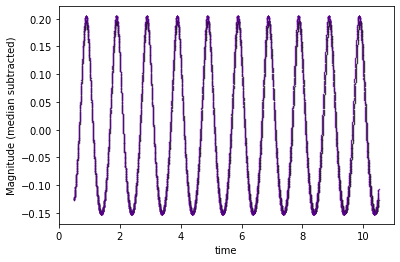

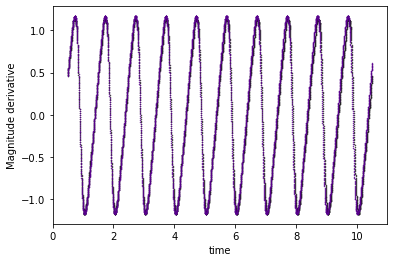

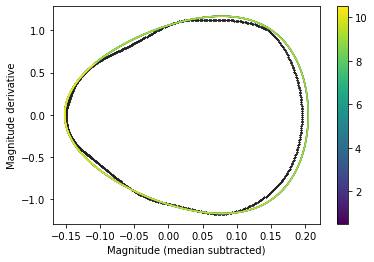

Governing equations:
x' = 1.001 xdot
xdot' = -3.431 1 + -51.076 x + 5.436 xdot^2
Initial conditions:
[-0.126434  0.462816]
Mean squared error: 0.020060313040481878
x' = 1.001 xdot
xdot' = -3.431 1 + -51.076 x + 5.436 xdot^2
True


In [40]:
model, MSE = sindyfy_lasso("./DeltaScuti9/3055031035294.csv", True, 0.05, 2, [0,0])
print("Mean squared error: " + str(MSE))
model.print()
mask_restrictedKhamsa = (model.coefficients() == 0)
print(all(model.coefficients()[mask_restrictedKhamsa] == 0))

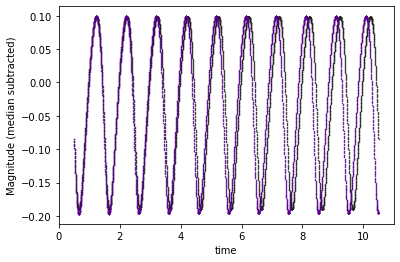

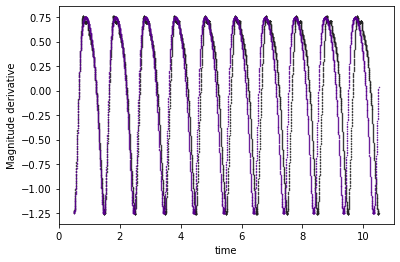

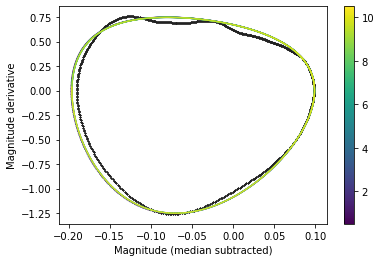

Governing equations:
x' = 0.996 xdot
xdot' = -46.890 x + 0.575 xdot + 35.768 x xdot + -3.643 xdot^2
Initial conditions:
[-0.085423 -1.249992]
Mean squared error: 0.2924820613642372
x' = 0.996 xdot
xdot' = -46.890 x + 0.575 xdot + 35.768 x xdot + -3.643 xdot^2
[[  0.           0.           0.99611108   0.           0.
    0.        ]
 [  0.         -46.89017153   0.57482754   0.          35.76823646
   -3.64278492]]
0.9961110804715674 0.0 46.89017152681445 0.5748275406943917 35.76823646370967 -3.64278492196276
0.08410905843972495 -0.11205032981954012 0.07829538548382585


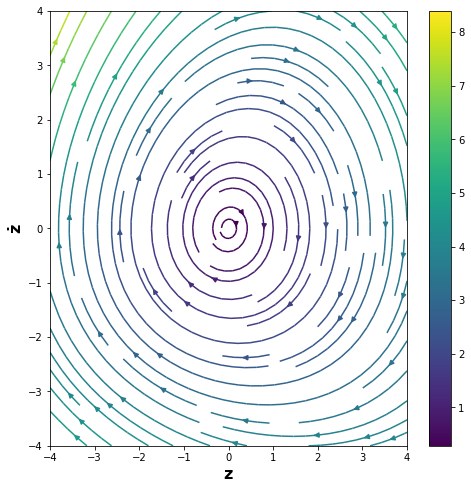

In [4]:
model, MSE = sindyfy_lasso("./DeltaScuti9/3035060033188.csv", True, 0.05, 2, [0,0])
print("Mean squared error: " + str(MSE))
model.print()
A = model.coefficients()[0,2]
B = model.coefficients()[1,0]
C = -model.coefficients()[1,1]
D = model.coefficients()[1,2]
E = model.coefficients()[1,4]
F = model.coefficients()[1,5]

print(model.coefficients())
print(A,B,C,D,E,F)
omega = np.sqrt(A*C)
a = (D + (E*B/C))/omega
b = - E/(A*C*omega) 
c = - F/(C*A*A)
print(a,b,c)

x, y = np.meshgrid(np.linspace(-4, 4, 20),
                   np.linspace(-4, 4, 20))

u = y
v = -x +a*y + b*x*y + c*y*y

plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
mag = norm(np.dstack([u, v]), axis=-1)
plt.streamplot(x, y, u, v, color=mag, cmap='viridis')

plt.colorbar()
plt.xlabel(r"$\mathbf{z}$", fontsize=16)
plt.ylabel(r"$\mathbf{\dot{z}}$", fontsize=16)
plt.show()

In [74]:
def calculateabc(filename):
    MSE = 1000.0
    for regu in [0.01, 0.02, 0.05, 0.1]:
        try:
            modelt, MSEt = sindyfy_lasso(filename, True, regu, 2, [0,0], silent=True)
        except:
            pass
        if(MSEt < MSE):
            MSE = MSEt
            model = modelt
    if(MSE>=1000.0): return(np.nan, np.nan, np.nan, np.nan)
    A = model.coefficients()[0,2]
    B = model.coefficients()[1,0]
    C = -model.coefficients()[1,1]
    D = model.coefficients()[1,2]
    E = model.coefficients()[1,4]
    F = model.coefficients()[1,5]
    omega = np.sqrt(A*C)
    a = (D + (E*B/C))/omega
    b = - E/(A*C*omega) 
    c = - F/(C*A*A)
    amplitude = (a*b+2*c)*(b+a*c)/(4.0*(a*a-4)) 
    #if(MSE<1): return(a,b,c,amplitude,MSE)
    return(a,b,c,amplitude,MSE)
    #return(np.nan, np.nan, np.nan, np.nan)

abc3021091024114 = calculateabc("./RRc2/3021091024114.csv")
abc3033094036811 = calculateabc("./DeltaScuti9/3033094036811.csv")
abc3035060033188 = calculateabc("./DeltaScuti9/3035060033188.csv")
abc3055031035294 = calculateabc("./DeltaScuti9/3055031035294.csv")
print(abc3021091024114)
print(abc3033094036811)
print(abc3035060033188)
print(abc3055031035294)

(0.037055014392891696, -0.06782442654718382, 0.035746307187701505, 0.000286793330974403, 0.050051846424944306)
(0.08564533930536003, -0.21222758648483903, 0.10578466847397713, 0.0024602116653257866, 0.122813127548894)
(0.09336587653858244, -0.11175833479499142, 0.08749729739313362, 0.001067741705793475, 0.021619845496434035)
(0.0, -0.0, -0.10623618593837202, -0.0, 0.020060313040481878)


In [75]:
bef = time.time()
someRRc2 = random.sample(os.listdir("./RRc2"),200)
starFileNames = [calculateabc(os.path.join("./RRc2/", filename)) for filename in someRRc2]
print(starFileNames)
af = time.time()
print(af - bef)

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wa

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wa

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wa

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wa

/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/anaconda3/envs/sindy/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  wa

[(0.19667790248208275, -0.06923651660754312, 0.05346825915527678, 0.00034582877858845815, 2.201068429620583), (0.047484737790599016, -0.11232795785700748, 0.01232779871847617, 0.00013501737809004994, 0.7418305903032412), (-0.15610205181952236, 6.646785731005872e-07, -4.024190019671082e-06, 6.627622956606761e-13, 1.0057499946143516), (-0.04275212134801587, -0.0, 0.04960001764607548, 1.31531518597951e-05, 1.0026350695572028), (-0.012975357483341088, -0.03840711443672504, -0.025037276671412804, -0.00011800330194301492, 0.0007848588378128221), (-0.06830983444390369, 0.01375855084475447, 0.004995434988303771, -7.598892593119661e-06, 1.2379481598362432), (-0.06409982127870809, 1.2244792502890125e-06, -3.354069685734831e-06, 6.112014779024602e-13, 0.9994115627551032), (-0.1930730716254154, -0.18727998679260904, -0.028575088709322044, -0.0002407099928167182, 0.8929360970627926), (-0.0655212152979752, -0.12908997731963617, -0.010103508984579441, -9.440667915568673e-05, 0.9167763689490697), (0.1

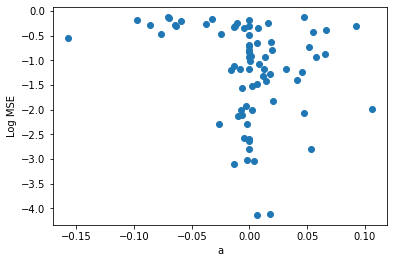

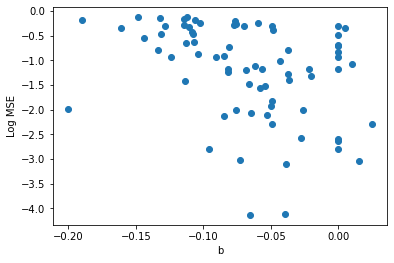

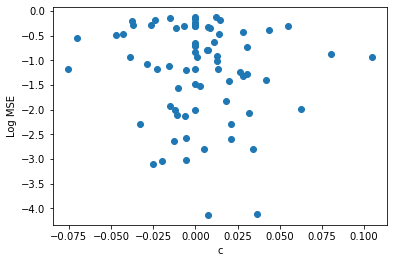

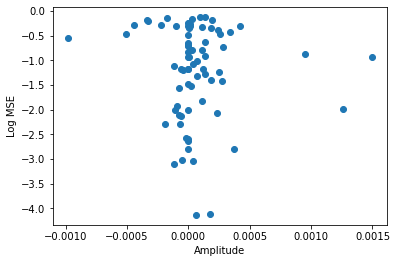

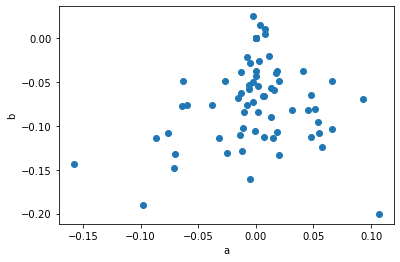

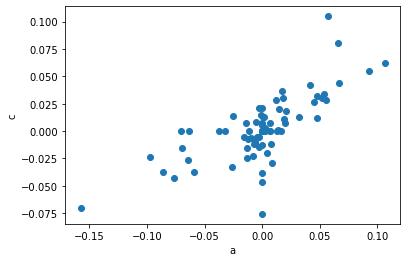

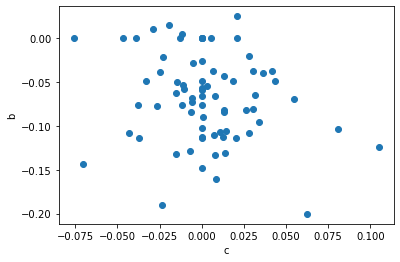

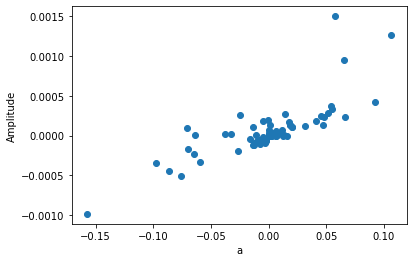

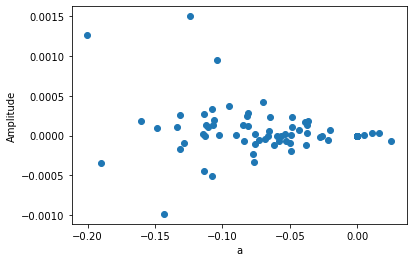

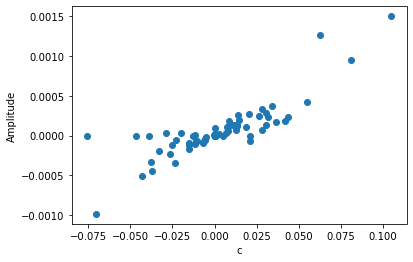

In [76]:
a_s = np.array([sf[0] for sf in starFileNames if len(sf)==5])
b_s = np.array([sf[1] for sf in starFileNames if len(sf)==5])
c_s = np.array([sf[2] for sf in starFileNames if len(sf)==5])
A_s = np.array([sf[3] for sf in starFileNames if len(sf)==5])
MSEs = np.array([sf[4] for sf in starFileNames if len(sf)==5])

MSEThreshold = 0.75
a_s = a_s[MSEs < MSEThreshold]
b_s = b_s[MSEs < MSEThreshold]
c_s = c_s[MSEs < MSEThreshold]
A_s = A_s[MSEs < MSEThreshold]
MSEs = MSEs[MSEs < MSEThreshold]

plt.scatter(a_s, np.log10(MSEs))
plt.xlabel("a")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(b_s, np.log10(MSEs))
plt.xlabel("b")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(c_s, np.log10(MSEs))
plt.xlabel("c")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(A_s, np.log10(MSEs))
plt.xlabel("Amplitude")
plt.ylabel("Log MSE")
plt.show()

plt.scatter(a_s, b_s)
plt.xlabel("a")
plt.ylabel("b")
plt.show()

plt.scatter(a_s, c_s)
plt.xlabel("a")
plt.ylabel("c")
plt.show()

plt.scatter(c_s, b_s)
plt.xlabel("c")
plt.ylabel("b")
plt.show()

plt.scatter(a_s, A_s)
plt.xlabel("a")
plt.ylabel("Amplitude")
plt.show()

plt.scatter(b_s, A_s)
plt.xlabel("a")
plt.ylabel("Amplitude")
plt.show()

plt.scatter(c_s, A_s)
plt.xlabel("c")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
total = 0
positive = 0
negative = 0
zeri = 0
for filename in os.listdir("./DeltaScuti9"):
    a,b,c,amp = calculateabc("./DeltaScuti9/"+filename)
    print(a,b,c,amp)
    total += 1
    if (amp>0): positive += 1
    if (amp<0): negative += 1
    if (amp == 0): zeri += 1
    
print(total, negative, positive, zeri)

In [ ]:
total = 0
positive = 0
negative = 0
zeri = 0
for filename in os.listdir("./RRc2"):
    try:
        a,b,c,amp = calculateabc("./RRc2/"+filename)
    except ValueError:
        pass    
    print(a,b,c,amp)
    total += 1
    if (amp>0): positive += 1
    if (amp<0): negative += 1
    if (amp == 0): zeri += 1
    
print(total, negative, positive, zeri)

##### What about some other star where the phase curve is not as symmetric?

In [ ]:
model, MSE = sindyfy_lasso("./DeltaScuti9/3027042040337.csv", True, 0.05, 2, [0,0])
print("Mean squared error: " + str(MSE))
model.print()
mask_generalKhamsa = (model.coefficients() == 0)
print(all(model.coefficients()[mask_generalKhamsa] == 0))
print(all(model.coefficients()[mask_restrictedKhamsa] == 0))

##### It looks like the system evolves towards a limit cycle, which is approached from within. Let's change the initial conditions to start it on the cycle.

In [ ]:
model, MSE = sindyfy_lasso("./DeltaScuti9/3027042040337.csv", True, 0.05, 2, [0,-0.2])
print("Mean squared error: " + str(MSE))

##### Looks pretty stable to me. What about starting from outside, will we spiral in?

In [ ]:
model, MSE = sindyfy_lasso("./DeltaScuti9/3027042040337.csv", True, 0.05, 2, [0,-0.5])
print("Mean squared error: " + str(MSE))

##### Well it looks like a limit cycle. Nice, right? 

## Let's have a closer look at the first case
##### The learned governing equations were in the form $\dot{x} = a_{02} y$, $\dot{y} = a_{10} + a_{11} x + a_{15} y^2$, which can be rewritten as a single equation $\ddot{x} = a + bx + c \dot{x}^2$. Without loss of generality we can set $a=0$ and $b=1$.

In [ ]:
x, y = np.meshgrid(np.linspace(-4, 4, 20),
                   np.linspace(-4, 4, 20))

c = 0.2

u = y
v = -x +c*y*y

plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
mag = norm(np.dstack([u, v]), axis=-1)
plt.streamplot(x, y, u, v, color=mag, cmap='viridis')
plt.colorbar()
plt.xlabel(r"$\mathbf{x}$", fontsize=16)
plt.ylabel(r"$\mathbf{\dot{x}}$", fontsize=16)
plt.show()

## and now at the second case:

In [ ]:
x, y = np.meshgrid(np.linspace(-4, 4, 20),
                   np.linspace(-4, 4, 20))

c = -0.01 #-0.3
d = 0.25
e = 0.25

u = y
v = -x +c*y + d*x*y + e*y*y

plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
mag = norm(np.dstack([u, v]), axis=-1)
plt.streamplot(x, y, u, v, color=mag, cmap='viridis')

#plt.axline([0,-c/e],[1,-(c+d)/e], color = "#B50012") #above this line the non-conservative forces do positive work, below negative

plt.colorbar()
plt.xlabel(r"$\mathbf{x}$", fontsize=16)
plt.ylabel(r"$\mathbf{\dot{x}}$", fontsize=16)
plt.show()

## Time to move to a larger sample
Here we fit a pysindy model to a sample of stars from each variable category. We count how many stars are fit by an harmonic oscillator or by a v^2 term. For each of these stars the original (spline smoothed, median subtracted; black lines) magnitude data is shown as a function of time (top plot) together with the corresponding the phase plot (bottom). The learned dynamical system is then evolved and the predicted evolution is overplotted (purple
line). The learned equations are reported after the last plot for each star. 

In [ ]:
def analyzeFolder(variableType):
    starList = os.listdir("./" + variableType + "/")
    MSEs = np.zeros(len(starList))
    rKhamsa = np.zeros(len(starList))
    gKhamsa = np.zeros(len(starList))
    for i in range(len(starList)):
        star = starList[i]
        bestMSE = 1000.0
        bestalpha = 0.0
        for alpha in [0.01, 0.02, 0.05, 0.1]:
            try:
                model, MSE = sindyfy_lasso("./" + variableType + "/" + star, True, alpha, 2, [0,0], silent=True)
            except:
                MSE = 1001.0
            if(MSE < bestMSE):
                bestalpha = alpha
                bestMSE = MSE
        try:
            model, MSE = sindyfy_lasso("./" + variableType + "/" + star, True, bestalpha, 2, [0,0], silent=True) #lookingForCaseStudies=True)
            if(all(model.coefficients()[mask_generalKhamsa] == 0)): gKhamsa[i] = 1 #harmonic oscillators and constants count
            if(all(model.coefficients()[mask_restrictedKhamsa] == 0)): rKhamsa[i] = 1
        except:
            MSE = 1001.0
            print("Star " + star + " failed.")
        if (MSE < 0.2): print("Star: " + star + ", MSE: " + str(MSE) + ", alpha = " + str(bestalpha))
        MSEs[i] = MSE
    return(MSEs, rKhamsa, gKhamsa)

start_time = time.time()

ds, dsrKhamsa, dsgKhamsa = analyzeFolder("DeltaScuti9")
print(np.sort(ds))
plt.hist(np.log10(ds[ds < 10.0]), color = "#E0C000")
plt.xlabel("MSE / MSE(0)")
plt.show()

print(str(sum(dsrKhamsa)))
print(str(sum(dsgKhamsa)))

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
rrc, rrcrKhamsa, rrcgKhamsa  = analyzeFolder("RRc2")
print(np.sort(rrc))
plt.hist(np.log10(rrc[rrc < 10.0]), color = "#C0E000")
plt.xlabel("MSE / MSE(0)")
plt.show()

print(str(sum(rrcrKhamsa)))
print(str(sum(rrcgKhamsa)))

In [ ]:
rrab, rrabrKhamsa, rrabgKhamsa = analyzeFolder("RRab1")
print(np.sort(rrab))
plt.hist(np.log10(rrab[rrab < 10.0]), color = "#888888")
plt.xlabel("MSE / MSE(0)")
plt.show()

print(str(sum(rrabrKhamsa)))
print(str(sum(rrabgKhamsa)))

In [ ]:
def histByKhamsa(mse, gKhamsa, mylegend):
    isgKhamsa = (gKhamsa==1)
    plt.hist([np.log10(mse[isgKhamsa])[mse[isgKhamsa] < 10], np.log10(mse[~isgKhamsa])[mse[~isgKhamsa] < 10]], color = ["#58008D", "#A0A0A8"], bins = 30, stacked=True, label = mylegend)
    plt.legend(prop={'size': 10})
    plt.xlim([-4,1])
    plt.xlabel("MSE / MSE(0)")
    plt.ylabel("Counts")
    plt.show()

histByKhamsa(ds, dsgKhamsa, ["٥", "other"])
histByKhamsa(rrab, rrabgKhamsa, ["٥", "other"])
histByKhamsa(rrc, rrcgKhamsa, ["٥", "other"])

histByKhamsa(ds, dsrKhamsa, ["٥, a=b=0", "other"])
histByKhamsa(rrab, rrabrKhamsa, ["٥, a=b=0", "other"])
histByKhamsa(rrc, rrcrKhamsa, ["٥, a=b=0", "other"])


print(len(ds[ds<1]))
print(len(rrc[rrc<1]))
print(len(rrab[rrab<1]))

print(ks_2samp(ds, rrc))
print(ks_2samp(ds, rrab))
print(ks_2samp(rrab, rrc))



In [ ]:
print(sum(dsgKhamsa))
print(sum(rrabgKhamsa))
print(sum(rrcgKhamsa))

In [ ]:
def chopoff(s):
    r = np.ones(len(s))
    for i in range(len(s)):
        ss = s[i]
        r[i] = int(ss[:-4])
    return(r)

In [ ]:
deltascutis = pd.read_csv("DeltaScuti9_Mario.csv")
rrcs = pd.read_csv("RRc2_Mario.csv")
rrabs = pd.read_csv("RRab1_Mario.csv")
ea6s = pd.read_csv("EA6_Mario.csv")
ewebs = pd.read_csv("EW_EB5_Mario.csv")
P_deltascutis = deltascutis["Period"].to_numpy()
A_deltascutis = deltascutis["Amp"].to_numpy()
Id_deltascutis = deltascutis["Numerical_ID"].to_numpy()
P_rrcs = rrcs["Period"].to_numpy()
A_rrcs = rrcs["Amp"].to_numpy()
Id_rrcs = rrcs["Numerical_ID"].to_numpy()
P_rrabs = rrabs["Period"].to_numpy()
A_rrabs = rrabs["Amp"].to_numpy()
Id_rrabs = rrabs["Numerical_ID"].to_numpy()
P_ea6s = ea6s["Period"].to_numpy()
A_ea6s = ea6s["Amp"].to_numpy()
Id_ea6s = ea6s["Numerical_ID"].to_numpy()
P_ewebs = ewebs["Period"].to_numpy()
A_ewebs = ewebs["Amp"].to_numpy()
Id_ewebs = ewebs["Numerical_ID"].to_numpy()

print(len(P_rrabs))
print(len(rrabgKhamsa))
print(any(np.isnan(P_rrabs)))

plt.ylabel("A (mag)")
plt.xlabel("P (days)")
plt.scatter(P_rrabs, A_rrabs, color="#A0A0A0")
plt.scatter(P_rrabs[rrabgKhamsa==1], A_rrabs[rrabgKhamsa==1], color = "#58008D")
plt.xlim([0,1])
plt.show() 

plt.ylabel("A (mag)")
plt.xlabel("P (days)")
plt.scatter(P_rrcs, A_rrcs, color="#A0A0A0")
plt.scatter(P_rrcs[rrcgKhamsa==1], A_rrcs[rrcgKhamsa==1], color = "#58008D")
plt.xlim([0,1])
plt.show() 

plt.ylabel("A (mag)")
plt.xlabel("P (days)")
plt.scatter(P_deltascutis, A_deltascutis, color="#A0A0A0")
plt.scatter(P_deltascutis[dsgKhamsa==1], A_deltascutis[dsgKhamsa==1], color = "#58008D")
plt.show() 



plt.ylabel("A (mag)")
plt.xlabel("P (days)")
rrab[rrab > 0.2] = 0.2
plt.scatter(P_rrabs, A_rrabs, c=rrab)
plt.colorbar()
plt.xlim([0,1])
plt.show() 

plt.ylabel("A (mag)")
plt.xlabel("P (days)")
rrc[rrc > 0.2] = 0.2
plt.scatter(P_rrcs, A_rrcs, c=rrc)
plt.colorbar()
plt.xlim([0,1])
plt.show() 

plt.ylabel("A (mag)")
plt.xlabel("P (days)")
ds[ds > 0.2] = 0.2
plt.scatter(P_deltascutis, A_deltascutis, c=ds)
plt.colorbar()
plt.show() 

### Some numerical experiments

In [ ]:
from scipy.integrate import odeint
from scipy.fft import fft, fftfreq

def dXdt(X,t,a=0,b=0,c=0.25):
    x = X[0]
    y = X[1]
    return([y, -x -y*(a + b*x + c*y)])

X0 = [0, 2]
t_end = 20000
steps_per_unit_time = 100
N = t_end*steps_per_unit_time
T = 1.0 / steps_per_unit_time
t = np.linspace(0,t_end, t_end*steps_per_unit_time)

a = -0.01
c = 0.25
bs = np.array([0.0, 0.25, 0.5])
for b in bs:
    X = odeint(dXdt, X0, t, args=(0.0,b,-0.25)) #-0.1, 0.9, 0.24 also sees stable, 0.0, 0.9, 0.24
    #print(X)
    plt.scatter(X[:,0], X[:,1], s=0.2, c=t[:])
    plt.axline([0,-a/c],[1,-(a+b)/c], color = "#B50012") #above this line the non-conservative forces do positive work, below negative
    plt.show()
    E = X[:,0]*X[:,0] + X[:,1]*X[:,1]
    plt.scatter(t, E, s=0.2)
    plt.show() 
    yf = fft(E)
    xf = fftfreq(N, T)[:N//2]
    plt.xlim([0,0.5])
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.show()
    #plt.scatter(X[(t_end-10)*steps_per_unit_time:,0], X[(t_end-10)*steps_per_unit_time:,1], s=0.2, c=t[(t_end-10)*steps_per_unit_time:])
    #plt.show()